In [1]:
### Let's read a sample audio using librosa
import librosa
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import sounddevice as sd
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import pandas as pd
import numpy as np
from tqdm import tqdm
import joblib
import os

In [2]:
audio_file_path = 'C:/Users/kboys/OneDrive/Desktop/Music-Genre-Classification-GTZAN/Data/genres_original/'

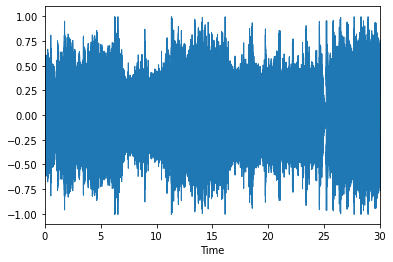

In [10]:
file_name = "rock/rock.00005.wav"
file = audio_file_path + f'{file_name}'
data,sample_rate=librosa.load(file)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(file)
# file

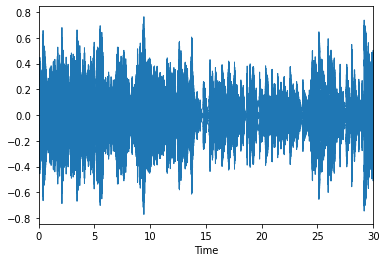

In [13]:
file_name = "jazz/jazz.00005.wav"
file = audio_file_path + f'{file_name}'
data,sample_rate=librosa.load(file)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(file)
# file

In [11]:
file_name = "classical/classical.00001.wav"
file = audio_file_path + f'{file_name}'
librosa_audio_data,librosa_sample_rate = librosa.load(file)
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
features = np.mean(mfccs.T, axis = 0) 
# print(features.shape)
# features

In [15]:
file_name = "classical/classical.00001.wav"
audio_class = "classical"

def load_mfcc(file_path, audio_class):
    
    librosa_audio_data,librosa_sample_rate = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
    features = np.mean(mfccs.T, axis = 0)
    
    return features

In [16]:
rootdir = audio_file_path
mfccs_extracts = []
classes = []

for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in (files):
        class_name = subdir.split("/")[-1] # genre name is assumed to be the folder name 
        file_path = os.path.join(subdir, file)
        
        mfccs_extracts.append(list(load_mfcc(file_path, class_name)))
        classes.append(class_name)
        

0it [00:00, ?it/s]c:\Users\kboys\anaconda3\envs\tensorflow\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
c:\Users\kboys\anaconda3\envs\tensorflow\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
11it [28:32, 155.65s/it]


In [73]:
# extract_dataframe = pd.DataFrame(mfccs_extracts)
# extract_dataframe["classes"] = classes
# extract_dataframe

In [74]:
mfccs_extracts = np.array(mfccs_extracts)
classes = np.array(classes)

In [75]:
mfccs_extracts.shape

(1001, 40)

In [76]:
labelencoder=LabelEncoder()
y = to_categorical(labelencoder.fit_transform(classes))

In [77]:
joblib.dump(labelencoder, 'label_encoder.joblib')
# label_encoder = joblib.load('label_encoder.joblib')

['label_encoder.joblib']

In [78]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(mfccs_extracts,y,test_size=0.2,random_state=0)
mfccs_extracts

array([[-1.13570648e+02,  1.21571793e+02, -1.91681423e+01, ...,
        -5.88924997e-02, -3.45850754e+00, -1.84239054e+00],
       [-2.07501694e+02,  1.23991264e+02,  8.95512676e+00, ...,
        -4.14923519e-01, -1.99414742e+00, -4.61869180e-01],
       [-9.07225952e+01,  1.40446304e+02, -2.90938892e+01, ...,
        -6.70301342e+00, -4.42440891e+00, -9.84265864e-01],
       ...,
       [-1.24952271e+02,  1.15177155e+02, -4.79751511e+01, ...,
        -4.19131708e+00, -3.78170252e+00, -3.88142657e+00],
       [-2.25007751e+02,  1.23646767e+02, -9.72417450e+00, ...,
        -1.46403265e+00, -4.59504932e-01, -1.21458852e+00],
       [-2.35161972e+02,  1.23870094e+02, -2.25383949e+01, ...,
        -5.95621061e+00, -5.25487757e+00,  1.78067636e+00]], dtype=float32)

#### MODEL CREATION BEGINS

In [79]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

2.3.0


In [17]:
### No of classes
num_labels=y.shape[1]

NameError: name 'y' is not defined

In [81]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [82]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_12 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_13 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)              

In [83]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [84]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/1000
 1/25 [>.............................] - ETA: 0s - loss: 41.5480 - accuracy: 0.1250
Epoch 00001: val_loss improved from inf to 4.19496, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 13ms/step - loss: 27.0923 - accuracy: 0.0962 - val_loss: 4.1950 - val_accuracy: 0.1443
Epoch 2/1000
 1/25 [>.............................] - ETA: 0s - loss: 17.0053 - accuracy: 0.0938
Epoch 00002: val_loss improved from 4.19496 to 2.69890, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 12.8736 - accuracy: 0.1238 - val_loss: 2.6989 - val_accuracy: 0.1393
Epoch 3/1000
 1/25 [>.............................] - ETA: 0s - loss: 7.6660 - accuracy: 0.2500
Epoch 00003: val_loss improved from 2.69890 to 2.21710, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 7.7583 - accuracy: 0.1238 - val_loss: 2.2171 - val_accuracy

25/25 [==============================] - 0s 4ms/step - loss: 2.1044 - accuracy: 0.2438 - val_loss: 1.9948 - val_accuracy: 0.3184
Epoch 28/1000
 1/25 [>.............................] - ETA: 0s - loss: 2.0876 - accuracy: 0.1875
Epoch 00028: val_loss did not improve from 1.99485
25/25 [==============================] - 0s 2ms/step - loss: 2.1146 - accuracy: 0.2463 - val_loss: 2.0158 - val_accuracy: 0.3234
Epoch 29/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.9940 - accuracy: 0.2812
Epoch 00029: val_loss improved from 1.99485 to 1.97777, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 8ms/step - loss: 2.0590 - accuracy: 0.2362 - val_loss: 1.9778 - val_accuracy: 0.3284
Epoch 30/1000
 1/25 [>.............................] - ETA: 0s - loss: 2.0952 - accuracy: 0.2500
Epoch 00030: val_loss improved from 1.97777 to 1.93519, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/s

Epoch 80/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.9767 - accuracy: 0.3438
Epoch 00080: val_loss improved from 1.58019 to 1.57586, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.6244 - accuracy: 0.4250 - val_loss: 1.5759 - val_accuracy: 0.4677
Epoch 81/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.4306 - accuracy: 0.4688
Epoch 00081: val_loss improved from 1.57586 to 1.56316, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.6363 - accuracy: 0.4137 - val_loss: 1.5632 - val_accuracy: 0.4527
Epoch 82/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.3861 - accuracy: 0.5312
Epoch 00082: val_loss improved from 1.56316 to 1.54746, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.5823 - accuracy: 0.4200 - val_loss: 1.5475 - val_accura

Epoch 107/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.6475 - accuracy: 0.4688
Epoch 00107: val_loss improved from 1.42876 to 1.42677, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 3ms/step - loss: 1.4758 - accuracy: 0.4925 - val_loss: 1.4268 - val_accuracy: 0.5323
Epoch 108/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.4577 - accuracy: 0.4688
Epoch 00108: val_loss improved from 1.42677 to 1.41379, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.4543 - accuracy: 0.4550 - val_loss: 1.4138 - val_accuracy: 0.5622
Epoch 109/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.2944 - accuracy: 0.4688
Epoch 00109: val_loss improved from 1.41379 to 1.40155, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.4320 - accuracy: 0.4837 - val_loss: 1.4015 - val_acc

 1/25 [>.............................] - ETA: 0s - loss: 1.0181 - accuracy: 0.7188
Epoch 00163: val_loss improved from 1.25973 to 1.25112, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.1276 - accuracy: 0.5838 - val_loss: 1.2511 - val_accuracy: 0.5423
Epoch 164/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.4913 - accuracy: 0.3125
Epoch 00164: val_loss did not improve from 1.25112
25/25 [==============================] - 0s 2ms/step - loss: 1.1568 - accuracy: 0.5838 - val_loss: 1.2764 - val_accuracy: 0.5423
Epoch 165/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.4859 - accuracy: 0.4375
Epoch 00165: val_loss did not improve from 1.25112
25/25 [==============================] - 0s 2ms/step - loss: 1.1525 - accuracy: 0.5825 - val_loss: 1.2757 - val_accuracy: 0.5622
Epoch 166/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.0304 - accuracy: 0.6250
Epoch 00166: val_loss d

Epoch 221/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9762 - accuracy: 0.7500
Epoch 00221: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.9125 - accuracy: 0.6875 - val_loss: 1.2743 - val_accuracy: 0.6070
Epoch 222/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8787 - accuracy: 0.6562
Epoch 00222: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.8825 - accuracy: 0.6787 - val_loss: 1.2837 - val_accuracy: 0.5821
Epoch 223/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.0050 - accuracy: 0.7500
Epoch 00223: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.9146 - accuracy: 0.6913 - val_loss: 1.2486 - val_accuracy: 0.6020
Epoch 224/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.1565 - accuracy: 0.5938
Epoch 00224: val_loss did not improve from 1.21429
25/25 [==========

Epoch 251/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7002 - accuracy: 0.8438
Epoch 00251: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.7932 - accuracy: 0.7212 - val_loss: 1.3518 - val_accuracy: 0.6020
Epoch 252/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8052 - accuracy: 0.7188
Epoch 00252: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.8381 - accuracy: 0.7150 - val_loss: 1.3326 - val_accuracy: 0.6269
Epoch 253/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6986 - accuracy: 0.7500
Epoch 00253: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.8569 - accuracy: 0.7275 - val_loss: 1.3432 - val_accuracy: 0.6119
Epoch 254/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8049 - accuracy: 0.7500
Epoch 00254: val_loss did not improve from 1.21429
25/25 [==========

Epoch 281/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9494 - accuracy: 0.6250
Epoch 00281: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.7967 - accuracy: 0.7312 - val_loss: 1.5144 - val_accuracy: 0.5821
Epoch 282/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9915 - accuracy: 0.7188
Epoch 00282: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.8116 - accuracy: 0.7237 - val_loss: 1.4462 - val_accuracy: 0.6169
Epoch 283/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7882 - accuracy: 0.6875
Epoch 00283: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.8080 - accuracy: 0.7237 - val_loss: 1.4661 - val_accuracy: 0.5970
Epoch 284/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7657 - accuracy: 0.7500
Epoch 00284: val_loss did not improve from 1.21429
25/25 [==========

25/25 [==============================] - 0s 2ms/step - loss: 0.7173 - accuracy: 0.7412 - val_loss: 1.5192 - val_accuracy: 0.5920
Epoch 311/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9609 - accuracy: 0.6250
Epoch 00311: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.7365 - accuracy: 0.7375 - val_loss: 1.4693 - val_accuracy: 0.6119
Epoch 312/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7172 - accuracy: 0.7188
Epoch 00312: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.7575 - val_loss: 1.4555 - val_accuracy: 0.6169
Epoch 313/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7368 - accuracy: 0.7188
Epoch 00313: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.7510 - accuracy: 0.7412 - val_loss: 1.4610 - val_accuracy: 0.6070
Epoch 314/1000
 1/25 [>..............

 1/25 [>.............................] - ETA: 0s - loss: 0.7731 - accuracy: 0.7500
Epoch 00340: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.7910 - accuracy: 0.7300 - val_loss: 1.5923 - val_accuracy: 0.6020
Epoch 341/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7292 - accuracy: 0.7500
Epoch 00341: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.7600 - val_loss: 1.5119 - val_accuracy: 0.6020
Epoch 342/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6087 - accuracy: 0.7812
Epoch 00342: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.7650 - val_loss: 1.6035 - val_accuracy: 0.5871
Epoch 343/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3620 - accuracy: 0.8750
Epoch 00343: val_loss did not improve from 1.21429
25/25 [=========================

Epoch 370/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5226 - accuracy: 0.8125
Epoch 00370: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.7862 - val_loss: 1.7192 - val_accuracy: 0.6119
Epoch 371/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5305 - accuracy: 0.8125
Epoch 00371: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.7750 - val_loss: 1.7424 - val_accuracy: 0.5871
Epoch 372/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8201 - accuracy: 0.7188
Epoch 00372: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6903 - accuracy: 0.7700 - val_loss: 1.5239 - val_accuracy: 0.6020
Epoch 373/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5131 - accuracy: 0.8125
Epoch 00373: val_loss did not improve from 1.21429
25/25 [==========

Epoch 400/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5972 - accuracy: 0.8125
Epoch 00400: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6394 - accuracy: 0.7725 - val_loss: 1.7191 - val_accuracy: 0.5920
Epoch 401/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7479 - accuracy: 0.7500
Epoch 00401: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6307 - accuracy: 0.7763 - val_loss: 1.6363 - val_accuracy: 0.5920
Epoch 402/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6084 - accuracy: 0.7188
Epoch 00402: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6514 - accuracy: 0.7775 - val_loss: 1.7568 - val_accuracy: 0.5821
Epoch 403/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.2408 - accuracy: 0.9688
Epoch 00403: val_loss did not improve from 1.21429
25/25 [==========

Epoch 430/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6940 - accuracy: 0.7500
Epoch 00430: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.7025 - accuracy: 0.7550 - val_loss: 1.6917 - val_accuracy: 0.5721
Epoch 431/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5141 - accuracy: 0.8125
Epoch 00431: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.7812 - val_loss: 1.7086 - val_accuracy: 0.6020
Epoch 432/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9301 - accuracy: 0.8125
Epoch 00432: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6332 - accuracy: 0.7775 - val_loss: 1.6635 - val_accuracy: 0.5920
Epoch 433/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5192 - accuracy: 0.7812
Epoch 00433: val_loss did not improve from 1.21429
25/25 [==========

Epoch 489/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4403 - accuracy: 0.8438
Epoch 00489: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5693 - accuracy: 0.8062 - val_loss: 1.7290 - val_accuracy: 0.6169
Epoch 490/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6695 - accuracy: 0.7812
Epoch 00490: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5841 - accuracy: 0.7962 - val_loss: 1.8644 - val_accuracy: 0.5920
Epoch 491/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3479 - accuracy: 0.8438
Epoch 00491: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5877 - accuracy: 0.8075 - val_loss: 1.8275 - val_accuracy: 0.5771
Epoch 492/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9458 - accuracy: 0.6250
Epoch 00492: val_loss did not improve from 1.21429
25/25 [==========

Epoch 519/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6517 - accuracy: 0.7188
Epoch 00519: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.7875 - val_loss: 2.0821 - val_accuracy: 0.6020
Epoch 520/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4500 - accuracy: 0.8750
Epoch 00520: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5746 - accuracy: 0.8037 - val_loss: 1.8588 - val_accuracy: 0.6070
Epoch 521/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4467 - accuracy: 0.8438
Epoch 00521: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5445 - accuracy: 0.8062 - val_loss: 1.9108 - val_accuracy: 0.6119
Epoch 522/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3108 - accuracy: 0.9062
Epoch 00522: val_loss did not improve from 1.21429
25/25 [==========

Epoch 549/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8132 - accuracy: 0.8438
Epoch 00549: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5622 - accuracy: 0.8100 - val_loss: 1.9282 - val_accuracy: 0.6269
Epoch 550/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7459 - accuracy: 0.7188
Epoch 00550: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.6128 - accuracy: 0.8062 - val_loss: 1.7992 - val_accuracy: 0.6119
Epoch 551/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5359 - accuracy: 0.8125
Epoch 00551: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.8175 - val_loss: 1.8323 - val_accuracy: 0.6119
Epoch 552/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4875 - accuracy: 0.8438
Epoch 00552: val_loss did not improve from 1.21429
25/25 [==========

Epoch 579/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3242 - accuracy: 0.9375
Epoch 00579: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5767 - accuracy: 0.8163 - val_loss: 2.0418 - val_accuracy: 0.6468
Epoch 580/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5207 - accuracy: 0.9062
Epoch 00580: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5484 - accuracy: 0.8087 - val_loss: 1.9906 - val_accuracy: 0.6020
Epoch 581/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7323 - accuracy: 0.6875
Epoch 00581: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.7962 - val_loss: 1.9464 - val_accuracy: 0.6169
Epoch 582/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5496 - accuracy: 0.7812
Epoch 00582: val_loss did not improve from 1.21429
25/25 [==========

Epoch 609/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8238 - accuracy: 0.7500
Epoch 00609: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5533 - accuracy: 0.8125 - val_loss: 2.0576 - val_accuracy: 0.6070
Epoch 610/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4849 - accuracy: 0.8125
Epoch 00610: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5487 - accuracy: 0.8125 - val_loss: 2.0588 - val_accuracy: 0.6070
Epoch 611/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6646 - accuracy: 0.7188
Epoch 00611: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5919 - accuracy: 0.7875 - val_loss: 1.9884 - val_accuracy: 0.6219
Epoch 612/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.8804 - accuracy: 0.6875
Epoch 00612: val_loss did not improve from 1.21429
25/25 [==========

Epoch 639/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5881 - accuracy: 0.7812
Epoch 00639: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5171 - accuracy: 0.8338 - val_loss: 1.9686 - val_accuracy: 0.6020
Epoch 640/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3665 - accuracy: 0.8438
Epoch 00640: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5200 - accuracy: 0.8238 - val_loss: 1.9932 - val_accuracy: 0.6020
Epoch 641/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3445 - accuracy: 0.8438
Epoch 00641: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5358 - accuracy: 0.8087 - val_loss: 2.0273 - val_accuracy: 0.6070
Epoch 642/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3422 - accuracy: 0.9375
Epoch 00642: val_loss did not improve from 1.21429
25/25 [==========

Epoch 669/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6620 - accuracy: 0.8125
Epoch 00669: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.8138 - val_loss: 2.1619 - val_accuracy: 0.6070
Epoch 670/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.9103 - accuracy: 0.6562
Epoch 00670: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5057 - accuracy: 0.8263 - val_loss: 2.0906 - val_accuracy: 0.6070
Epoch 671/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6118 - accuracy: 0.8438
Epoch 00671: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5585 - accuracy: 0.8200 - val_loss: 2.1664 - val_accuracy: 0.6119
Epoch 672/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5654 - accuracy: 0.7812
Epoch 00672: val_loss did not improve from 1.21429
25/25 [==========

Epoch 699/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4036 - accuracy: 0.8438
Epoch 00699: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8512 - val_loss: 2.2685 - val_accuracy: 0.6070
Epoch 700/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3881 - accuracy: 0.9375
Epoch 00700: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5068 - accuracy: 0.8275 - val_loss: 2.2779 - val_accuracy: 0.6020
Epoch 701/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.2766 - accuracy: 0.6562
Epoch 00701: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5671 - accuracy: 0.8050 - val_loss: 2.2479 - val_accuracy: 0.5970
Epoch 702/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4142 - accuracy: 0.8750
Epoch 00702: val_loss did not improve from 1.21429
25/25 [==========

Epoch 729/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6392 - accuracy: 0.8438
Epoch 00729: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5333 - accuracy: 0.8350 - val_loss: 2.1607 - val_accuracy: 0.6219
Epoch 730/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5674 - accuracy: 0.8125
Epoch 00730: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5284 - accuracy: 0.8225 - val_loss: 2.0440 - val_accuracy: 0.5920
Epoch 731/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4853 - accuracy: 0.8438
Epoch 00731: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5196 - accuracy: 0.8075 - val_loss: 2.2065 - val_accuracy: 0.5821
Epoch 732/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3261 - accuracy: 0.9062
Epoch 00732: val_loss did not improve from 1.21429
25/25 [==========

Epoch 759/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5290 - accuracy: 0.8125
Epoch 00759: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4969 - accuracy: 0.8438 - val_loss: 2.4105 - val_accuracy: 0.6020
Epoch 760/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5586 - accuracy: 0.8125
Epoch 00760: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.8238 - val_loss: 2.3379 - val_accuracy: 0.5721
Epoch 761/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5946 - accuracy: 0.7188
Epoch 00761: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5044 - accuracy: 0.8238 - val_loss: 2.3754 - val_accuracy: 0.6020
Epoch 762/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7308 - accuracy: 0.7500
Epoch 00762: val_loss did not improve from 1.21429
25/25 [==========

Epoch 789/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3149 - accuracy: 0.9062
Epoch 00789: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.8562 - val_loss: 2.3787 - val_accuracy: 0.6119
Epoch 790/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4903 - accuracy: 0.9062
Epoch 00790: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4827 - accuracy: 0.8375 - val_loss: 2.4232 - val_accuracy: 0.5821
Epoch 791/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6008 - accuracy: 0.8125
Epoch 00791: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5371 - accuracy: 0.8275 - val_loss: 2.2997 - val_accuracy: 0.6070
Epoch 792/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4512 - accuracy: 0.8438
Epoch 00792: val_loss did not improve from 1.21429
25/25 [==========

Epoch 848/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3515 - accuracy: 0.9375
Epoch 00848: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.8625 - val_loss: 2.3508 - val_accuracy: 0.5920
Epoch 849/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5654 - accuracy: 0.8125
Epoch 00849: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4823 - accuracy: 0.8400 - val_loss: 2.3038 - val_accuracy: 0.6020
Epoch 850/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4134 - accuracy: 0.8438
Epoch 00850: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.5103 - accuracy: 0.8338 - val_loss: 2.3611 - val_accuracy: 0.6119
Epoch 851/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7263 - accuracy: 0.7812
Epoch 00851: val_loss did not improve from 1.21429
25/25 [==========

Epoch 878/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3980 - accuracy: 0.8750
Epoch 00878: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.8275 - val_loss: 2.5422 - val_accuracy: 0.5721
Epoch 879/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.6568 - accuracy: 0.7188
Epoch 00879: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5181 - accuracy: 0.8125 - val_loss: 2.6857 - val_accuracy: 0.5821
Epoch 880/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3734 - accuracy: 0.8438
Epoch 00880: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.8438 - val_loss: 2.4933 - val_accuracy: 0.5721
Epoch 881/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.2647 - accuracy: 0.9062
Epoch 00881: val_loss did not improve from 1.21429
25/25 [==========

Epoch 908/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4761 - accuracy: 0.7812
Epoch 00908: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.8250 - val_loss: 2.7531 - val_accuracy: 0.5721
Epoch 909/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5650 - accuracy: 0.7500
Epoch 00909: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.8313 - val_loss: 2.6676 - val_accuracy: 0.5920
Epoch 910/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4692 - accuracy: 0.8125
Epoch 00910: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.8438 - val_loss: 2.5933 - val_accuracy: 0.6020
Epoch 911/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4089 - accuracy: 0.7812
Epoch 00911: val_loss did not improve from 1.21429
25/25 [==========

Epoch 938/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5575 - accuracy: 0.7812
Epoch 00938: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4975 - accuracy: 0.8263 - val_loss: 2.4025 - val_accuracy: 0.5871
Epoch 939/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5861 - accuracy: 0.8438
Epoch 00939: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4794 - accuracy: 0.8438 - val_loss: 2.3281 - val_accuracy: 0.5871
Epoch 940/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7518 - accuracy: 0.7188
Epoch 00940: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.5062 - accuracy: 0.8188 - val_loss: 2.3049 - val_accuracy: 0.5771
Epoch 941/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5904 - accuracy: 0.7812
Epoch 00941: val_loss did not improve from 1.21429
25/25 [==========

Epoch 968/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.5421 - accuracy: 0.7500
Epoch 00968: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4910 - accuracy: 0.8300 - val_loss: 2.5920 - val_accuracy: 0.5920
Epoch 969/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4796 - accuracy: 0.8125
Epoch 00969: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4575 - accuracy: 0.8462 - val_loss: 2.6503 - val_accuracy: 0.5721
Epoch 970/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4719 - accuracy: 0.8125
Epoch 00970: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4666 - accuracy: 0.8388 - val_loss: 2.5749 - val_accuracy: 0.5721
Epoch 971/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4822 - accuracy: 0.8125
Epoch 00971: val_loss did not improve from 1.21429
25/25 [==========

Epoch 998/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.7427 - accuracy: 0.8125
Epoch 00998: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4310 - accuracy: 0.8650 - val_loss: 2.2508 - val_accuracy: 0.5871
Epoch 999/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.4129 - accuracy: 0.8438
Epoch 00999: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 3ms/step - loss: 0.4570 - accuracy: 0.8487 - val_loss: 2.3746 - val_accuracy: 0.5721
Epoch 1000/1000
 1/25 [>.............................] - ETA: 0s - loss: 0.3123 - accuracy: 0.8750
Epoch 01000: val_loss did not improve from 1.21429
25/25 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.8375 - val_loss: 2.3797 - val_accuracy: 0.5721
Training completed in time:  0:01:10.994841


In [85]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('saved_models/audio_classification.h5')

In [86]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.572139322757721


In [62]:
X_test[1]

array([-0.92669773,  0.5187589 , -0.30097046,  0.64880747, -1.0137646 ,
        0.30230415, -0.8893961 ,  0.50158995, -1.2726343 ,  0.71708924,
       -0.03096831,  0.6208461 , -0.3956167 ,  0.6011729 , -0.10682684,
        0.73500437, -0.06552874,  0.46818456, -2.025098  , -0.84365284,
        0.25908852, -0.6971739 , -0.05732179, -0.76276845, -0.00317129,
       -1.7469178 , -1.3103007 , -0.49652582, -0.8113225 , -0.22310692,
        0.7873357 , -0.48206228, -0.60120595, -0.2213232 ,  0.74666935,
       -0.6072422 ,  1.1541184 ,  0.04380576, -0.4154896 , -2.2759037 ],
      dtype=float32)

In [78]:
# filename="C:/Users/kboys/OneDrive/Desktop/Music-Genre-Classification-GTZAN/Data/genres_original/blues/blues.00005.wav"
# audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
# mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
# mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

# # print(mfccs_scaled_features)
# mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
# # print(mfccs_scaled_features)
# # print(mfccs_scaled_features.shape)
# predicted_label=model.predict_classes(mfccs_scaled_features)
# # print(predicted_label)
# prediction_class = labelencoder.inverse_transform(predicted_label) 
# prediction_class

array(['blues'], dtype='<U9')

##### TEST CUT AUDIO TO 30 SECONDS USING PYDUB AND FFMPEG

In [63]:
from pydub import AudioSegment

def cut_song(filepath):
    
    sound = AudioSegment.from_file(filepath)
    print(filepath)

    halfway_point = len(sound) // 2
    first_half = sound[halfway_point:halfway_point+30000]
    print(len(sound))

    # create a new file "first_half.mp3":
    destination = r"C:\Users\kboys\OneDrive\Desktop\temp.wav"
    first_half.export(destination, format="wav")
    
    return destination

In [70]:
filename="C:/Users/kboys/OneDrive/Desktop/Music-Genre-Classification-GTZAN/Data/genres_original/country/country.00008.wav"

def predict_genre(filepath):
    print(filepath)
    file_name = cut_song(filepath)
    print(")00000000000000000000000(")
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label=model.predict_classes(mfccs_scaled_features)
    label_encoder = joblib.load('label_encoder.joblib')
    prediction_class = labelencoder.inverse_transform(predicted_label) 
    
    return prediction_class

In [71]:
predict_genre(filename)

C:/Users/kboys/OneDrive/Desktop/Music-Genre-Classification-GTZAN/Data/genres_original/country/country.00008.wav
C:/Users/kboys/OneDrive/Desktop/Music-Genre-Classification-GTZAN/Data/genres_original/country/country.00008.wav
30102
)00000000000000000000000(


array(['jazz'], dtype='<U9')

##### USING SOUND RECORD

In [ ]:
def record_sound():

    fs = 44100  # Sample rate
    seconds = 30  # Duration of recording
    print("Start record..!!")

    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()  # Wait until recording is finished
    write(r"C:\Users\kboys\OneDrive\Desktop\sample.wav", fs, myrecording)  # Save as WAV file 
    
    print("End record..!!")
    
    return r"C:\Users\kboys\OneDrive\Desktop\sample.wav"

In [ ]:

def predict_genre():
    
    file_name = record_sound()
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label=model.predict_classes(mfccs_scaled_features)
    prediction_class = labelencoder.inverse_transform(predicted_label) 
    
    return prediction_class

In [32]:
for i in range(20):
    print(predict_genre())

NameError: name 'predict_genre' is not defined

In [34]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('saved_models/audio_classification.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2